In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [18]:
from pickle import load
from pickle import dump
from myTools import *
import datetime

from lightgbm import LGBMClassifier

In [19]:
dfApplication = load(open('dfApplicationTrain.pkl','rb'))

In [20]:
#dfApplication, dfApplicationVal = train_test_split(dfApplicationComplete, test_size=0.3, random_state=1)

In [21]:
dfApplicationDefault = load(open('dfApplicationDefault.pkl','rb'))
dfApplicationDefault = dfApplicationDefault.merge(dfApplication[['SK_ID_CURR']], left_on='SK_ID_CURR', right_on='SK_ID_CURR')

In [24]:
def imputeScaleAndEncode(df1, 
                    target='', 
                    identifier=''):
    
    df = df1.copy()
    
    if type(target) == str:
        target = [target]
    if type(identifier) == str:
        identifier = [identifier]
    
    colToExclude = target
    colToExclude.extend(identifier)
    
    for col in df.columns:
        if col not in colToExclude:
            if df[col].dtypes == 'object':
                df[col] = df[col].replace(np.nan, 'missing')
                df[col] = OrdinalEncoder().fit_transform(df[[col]])
            elif df[col].dtype in ['int64','float64']:
                df[col] = SimpleImputer(strategy='mean').fit_transform(df[[col]])
                df[col] = MinMaxScaler().fit_transform(df[[col]])  
                
    return df


In [22]:
results = []

# Evaluation sur les jeux de données par défaut et travaillés + paramètres optimisés précédemment

In [8]:
model = LGBMClassifier()

res = evaluateRocPrCurves(dfApplicationDefault, model=model, title_plot='Default data', display_plot=False, target='TARGET', identifier='SK_ID_CURR')
results.append(res)

res = evaluateRocPrCurves(dfApplication, model=model, title_plot='Worked data', display_plot=False, target='TARGET', identifier='SK_ID_CURR')
results.append(res)

model = LGBMClassifier(max_depth=4, learning_rate=0.1, num_leaves=8, min_child_samples=200, subsample_for_bin=25000, n_estimators=250, n_jobs=-1)

res = evaluateRocPrCurves(dfApplication, model=model, title_plot='Optim param 1', display_plot=False, target='TARGET', identifier='SK_ID_CURR')
results.append(res)

pd.concat(results).groupby('title').mean().reset_index().sort_values('timestamp').reset_index(drop=True)

KeyboardInterrupt: 

# Suppression des features avec importance nulle

In [ ]:
#https://www.kaggle.com/kylegilde/extracting-scikit-feature-names-importances
#https://towardsdatascience.com/extracting-feature-importances-from-scikit-learn-pipelines-18c79b4ae09a
#https://towardsdatascience.com/how-to-get-feature-importances-from-any-sklearn-pipeline-167a19f1214

In [ ]:
model = LGBMClassifier(max_depth=4, learning_rate=0.1, num_leaves=8, min_child_samples=200, subsample_for_bin=25000, n_estimators=250, n_jobs=-1)
imp = featureImportance(imputeScaleAndEncode(dfApplication, target='TARGET', identifier='SK_ID_CURR'), target='TARGET', identifier='SK_ID_CURR', model=model)
imp[['feature','impMean']]

In [ ]:
cols = ['SK_ID_CURR','TARGET']
cols.extend(list(imp[imp.impMean > 0].feature))
cols

In [ ]:
for index, row in imp.iterrows():
    if row.impMean == 0:
        del dfApplication[row.feature]

In [ ]:
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='Data importance > 0', display_plot=False, target='TARGET', identifier='SK_ID_CURR')

results.append(res)
pd.concat(results).groupby('title').mean().reset_index().sort_values('timestamp').reset_index(drop=True)

# Optimisation des paramètres

In [ ]:
results_tmp = []
lst = [2, 3, 4, 5, 6, 7, 8, 9, 10]
for param_value in lst:
    model = LGBMClassifier(max_depth=param_value, learning_rate=0.1, num_leaves=8, min_child_samples=200, subsample_for_bin=25000, n_estimators=250, n_jobs=-1)
    title = 'LGBMClassifier | max_depth = ' + str(param_value)
    res = evaluate(dfApplication, model=model, title=title)
    results_tmp.append(res)
    
displayPlotParamOptim(results_tmp)

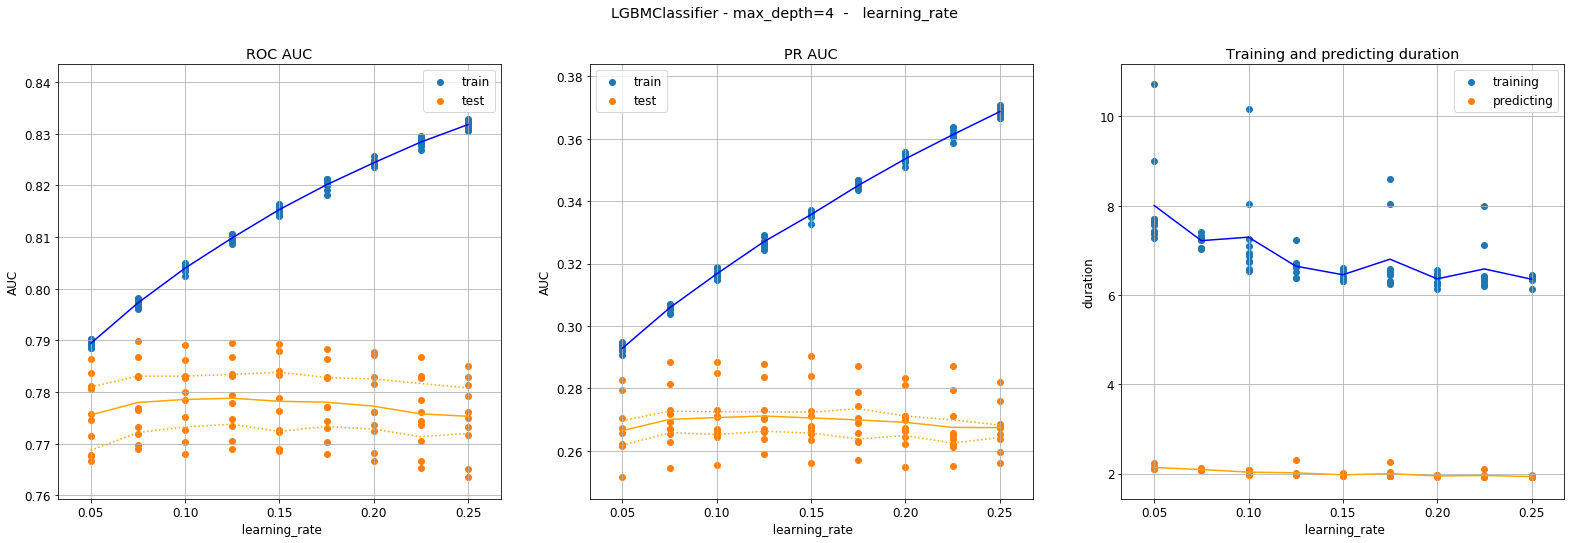

In [62]:
results_tmp = []
lst = [0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25]
for param_value in lst:
    print(param_value)
    model = LGBMClassifier(max_depth=7, learning_rate=param_value, num_leaves=8, min_child_samples=200, subsample_for_bin=25000, n_estimators=250, n_jobs=-1)
    title = 'LGBMClassifier |  learning_rate = ' + str(param_value)
    res = evaluate(dfApplication, model=model, title=title)
    results_tmp.append(res)
    
displayPlotParamOptim(results_tmp)

results.extend(results_tmp)

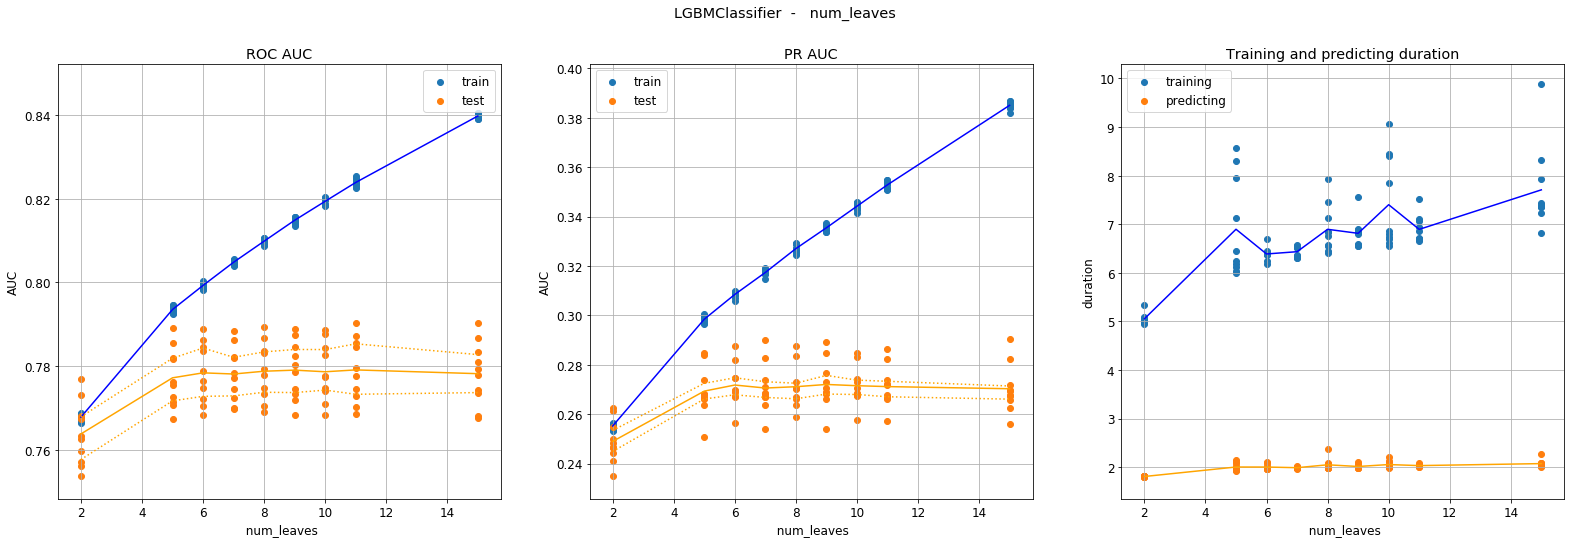

In [66]:
results_tmp = []
lst = [2, 5, 6, 7, 8, 9, 10, 11, 15]
for param_value in lst:
    print(param_value)
    model = LGBMClassifier(max_depth=7, learning_rate=0.125, num_leaves=param_value, min_child_samples=200, subsample_for_bin=25000, n_estimators=250, n_jobs=-1)
    title = 'LGBMClassifier |  num_leaves = ' + str(param_value)
    res = evaluate(dfApplication, model=model, title=title)
    results_tmp.append(res)
    
displayPlotParamOptim(results_tmp)


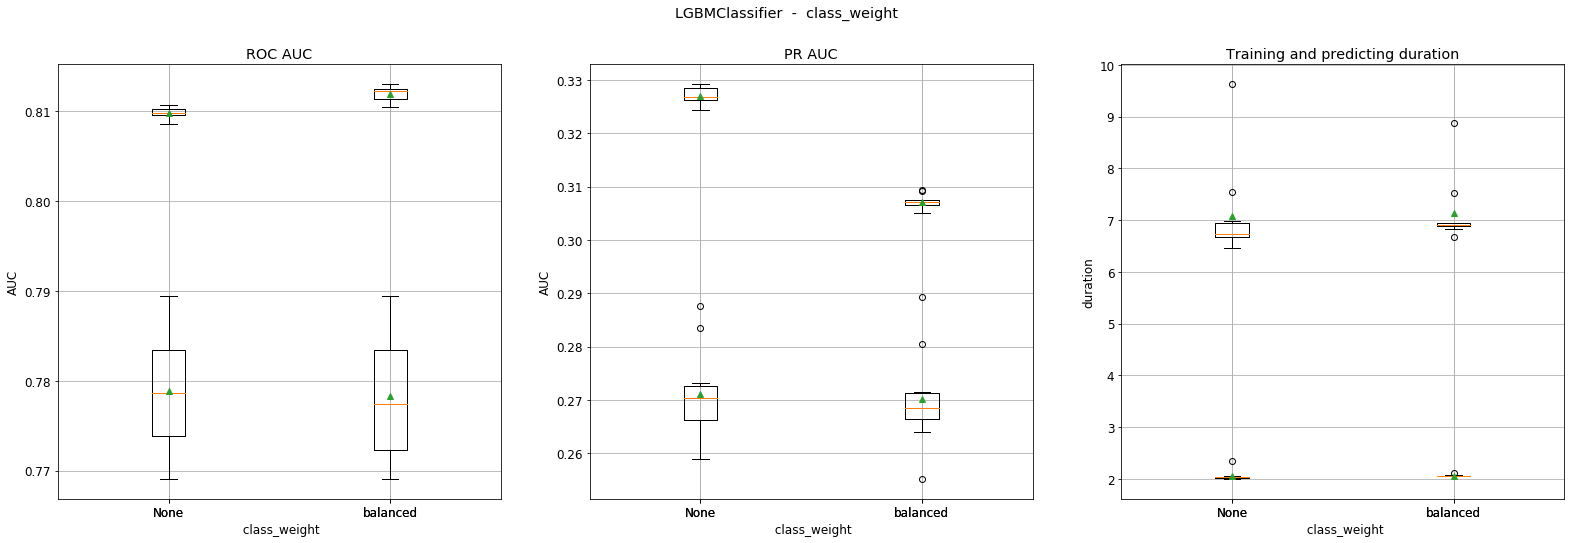

In [69]:
results_tmp = []

model = LGBMClassifier(max_depth=7, learning_rate=0.125, num_leaves=8, class_weight=None, min_child_samples=200, subsample_for_bin=25000, n_estimators=250, n_jobs=-1)
title = 'LGBMClassifier | class_weight=None'
res = evaluate(dfApplication, model=model, title=title)
results_tmp.append(res)

model = LGBMClassifier(max_depth=7, learning_rate=0.125, num_leaves=8, class_weight='balanced', min_child_samples=200, subsample_for_bin=25000, n_estimators=250, n_jobs=-1)
title = 'LGBMClassifier | class_weight=balanced'
res = evaluate(dfApplication, model=model, title=title)
results_tmp.append(res)

displayPlotParamOptimBox(results_tmp)

In [ ]:
results_tmp = []
lst = [10, 50, 100, 150, 200, 250, 300, 500]
for param_value in lst:
    print(param_value)
    model = LGBMClassifier(max_depth=7, learning_rate=0.125, num_leaves=8, min_child_samples=param_value, subsample_for_bin=25000, n_estimators=250, n_jobs=-1)
    title = 'LGBMClassifier |  num_leaves = ' + str(param_value)
    res = evaluate(dfApplication, model=model, title=title)
    results_tmp.append(res)
    
displayPlotParamOptim(results_tmp)


50
500
5000
10000
25000
50000


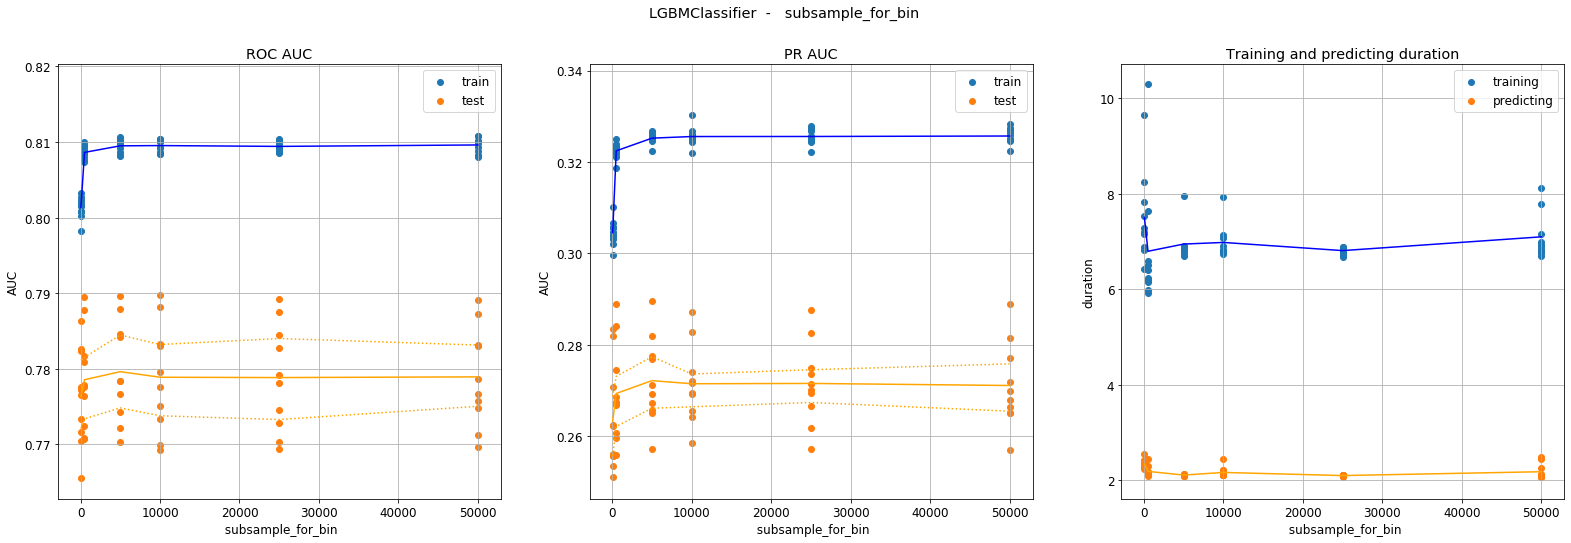

In [89]:
results_tmp = []
lst = [50, 500, 5000, 10000, 25000, 50000]
for param_value in lst:
    print(param_value)
    model = LGBMClassifier(max_depth=7, learning_rate=0.125, num_leaves=8, min_child_samples=300, subsample_for_bin=param_value, n_estimators=250, n_jobs=-1)
    title = 'LGBMClassifier |  subsample_for_bin = ' + str(param_value)
    res = evaluate(dfApplication, model=model, title=title)
    results_tmp.append(res)
    
displayPlotParamOptim(results_tmp)


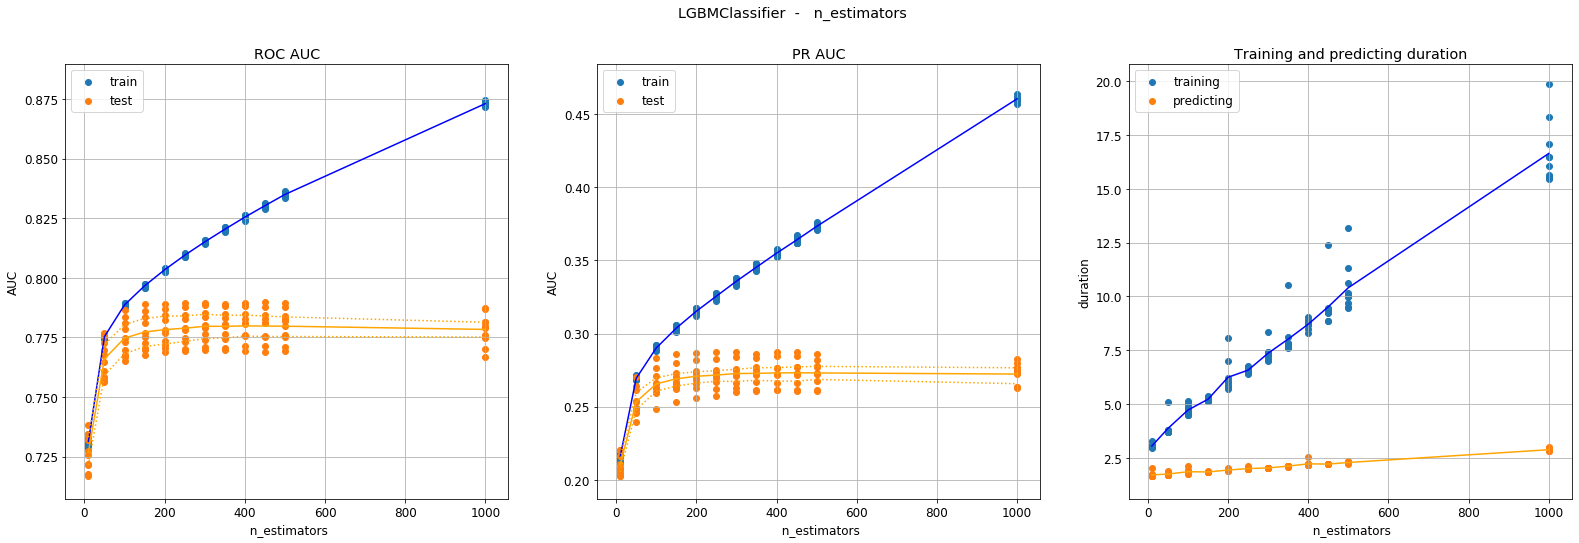

In [91]:
#results_tmp = []
lst = [10, 50, 100, 150, 200, 250, 300, 500, 1000]
lst = [350, 400, 450]
for param_value in lst:
    model = LGBMClassifier(max_depth=7, learning_rate=0.125, num_leaves=8, min_child_samples=300, subsample_for_bin=25000, n_estimators=param_value, n_jobs=-1)
    title = 'LGBMClassifier |  n_estimators = ' + str(param_value)
    res = evaluate(dfApplication, model=model, title=title)
    results_tmp.append(res)
    
displayPlotParamOptim(results_tmp)

In [12]:
model = LGBMClassifier(max_depth=7, learning_rate=0.125, num_leaves=8, min_child_samples=300, subsample_for_bin=25000, n_estimators=300, n_jobs=-1)
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='Optim param 2', display_plot=False, target='TARGET', identifier='SK_ID_CURR')

results.append(res)
pd.concat(results).groupby('title').mean().reset_index().sort_values('timestamp').reset_index(drop=True)

,title,roc_auc_train,roc_auc_test,pr_auc_train,pr_auc_test,time_train,time_pred,nb_feat,nb_train,timestamp
0,Default data,0.830893,0.771604,0.376599,0.259588,7.251113,2.199451,202,182349,1.615875e+09
1,Worked data,0.837280,0.777820,0.388404,0.267171,8.089405,2.221264,228,182349,1.615875e+09
2,Data importance > 0,0.806461,0.781423,0.318548,0.273607,6.648398,1.974747,152,182349,1.615875e+09
3,Optim param,0.818923,0.782068,0.339935,0.274388,7.344924,2.016068,152,182349,1.615875e+09


# Optimisation des imputers

In [14]:
model = LGBMClassifier(max_depth=7, learning_rate=0.125, num_leaves=8, min_child_samples=300, subsample_for_bin=25000, n_estimators=300, n_jobs=-1)

## Optimisation des defaultImputer

### Variables catégorielles

In [15]:
results_tmp = []

defaultCatImputer = SimpleImputer(strategy='constant', fill_value='missing')
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='defaultCatImputer = missing', display_plot=False, target='TARGET', identifier='SK_ID_CURR',defaultCatImputer=defaultCatImputer)
results_tmp.append(res)

defaultCatImputer = SimpleImputer(strategy='most_frequent')
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='defaultCatImputer = most_frequent', display_plot=False, target='TARGET', identifier='SK_ID_CURR',defaultCatImputer=defaultCatImputer)
results_tmp.append(res)

pd.concat(results_tmp).groupby('title').mean().reset_index().sort_values('timestamp').reset_index(drop=True)

,title,roc_auc_train,roc_auc_test,pr_auc_train,pr_auc_test,time_train,time_pred,nb_feat,nb_train,timestamp
0,defaultCatImputer = missing,0.819078,0.781964,0.339811,0.273486,9.123535,2.267463,152,182349,1.615875e+09
1,defaultCatImputer = most_frequent,0.818923,0.782068,0.339935,0.274388,12.245367,2.472312,152,182349,1.615876e+09


### Variables ordinales

In [17]:
results_tmp = []

defaultCatImputer = SimpleImputer(strategy='most_frequent')
defaultOrdImputer = SimpleImputer(strategy='most_frequent')
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='defaultOrdImputer = most_frequent', display_plot=False, target='TARGET', identifier='SK_ID_CURR',defaultCatImputer=defaultCatImputer,defaultOrdImputer=defaultOrdImputer)
results_tmp.append(res)

defaultCatImputer = SimpleImputer(strategy='most_frequent')
defaultOrdImputer = SimpleImputer(strategy='mean')
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='defaultOrdImputer = mean', display_plot=False, target='TARGET', identifier='SK_ID_CURR',defaultCatImputer=defaultCatImputer,defaultOrdImputer=defaultOrdImputer)
results_tmp.append(res)

defaultCatImputer = SimpleImputer(strategy='most_frequent')
defaultOrdImputer = SimpleImputer(strategy='constant', fill_value=-1)
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='defaultOrdImputer = -1', display_plot=False, target='TARGET', identifier='SK_ID_CURR',defaultCatImputer=defaultCatImputer,defaultOrdImputer=defaultOrdImputer)
results_tmp.append(res)

defaultCatImputer = SimpleImputer(strategy='most_frequent')
defaultOrdImputer = IterativeImputer()
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='defaultOrdImputer = iterative', display_plot=False, target='TARGET', identifier='SK_ID_CURR',defaultCatImputer=defaultCatImputer,defaultOrdImputer=defaultOrdImputer)
results_tmp.append(res)

pd.concat(results_tmp).groupby('title').mean().reset_index().sort_values('timestamp').reset_index(drop=True)

/home/pierre/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
/home/pierre/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
/home/pierre/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
/home/pierre/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
/home/pierre/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:685: Con

,title,roc_auc_train,roc_auc_test,pr_auc_train,pr_auc_test,time_train,time_pred,nb_feat,nb_train,timestamp
0,defaultOrdImputer = most_frequent,0.818923,0.782068,0.339935,0.274388,6.903162,1.650537,152,182349,1.615877e+09
1,defaultOrdImputer = mean,0.818925,0.781747,0.339512,0.273386,5.478532,1.529181,152,182349,1.615877e+09
2,defaultOrdImputer = -1,0.818928,0.781943,0.340153,0.274198,5.106351,1.478007,152,182349,1.615877e+09
3,defaultOrdImputer = iterative,0.819297,0.781982,0.340110,0.273268,28.361580,2.119281,152,182349,1.615878e+09


### Variables continues

In [19]:
results_tmp = []

defaultCatImputer = SimpleImputer(strategy='most_frequent')
defaultOrdImputer = SimpleImputer(strategy='most_frequent')
defaultNumImputer = SimpleImputer(strategy='constant', fill_value=-1)
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='defaultNumImputer = -1', display_plot=False, target='TARGET', identifier='SK_ID_CURR',defaultCatImputer=defaultCatImputer,defaultOrdImputer=defaultOrdImputer,defaultNumImputer=defaultNumImputer)
results_tmp.append(res)

defaultCatImputer = SimpleImputer(strategy='most_frequent')
defaultOrdImputer = SimpleImputer(strategy='most_frequent')
defaultNumImputer = SimpleImputer(strategy='mean')
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='defaultNumImputer = mean', display_plot=False, target='TARGET', identifier='SK_ID_CURR',defaultCatImputer=defaultCatImputer,defaultOrdImputer=defaultOrdImputer,defaultNumImputer=defaultNumImputer)
results_tmp.append(res)

defaultCatImputer = SimpleImputer(strategy='most_frequent')
defaultOrdImputer = SimpleImputer(strategy='most_frequent')
defaultNumImputer = IterativeImputer()
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='defaultNumImputer = iterative', display_plot=False, target='TARGET', identifier='SK_ID_CURR',defaultCatImputer=defaultCatImputer,defaultOrdImputer=defaultOrdImputer,defaultNumImputer=defaultNumImputer)
results_tmp.append(res)

pd.concat(results_tmp).groupby('title').mean().reset_index().sort_values('timestamp').reset_index(drop=True)

,title,roc_auc_train,roc_auc_test,pr_auc_train,pr_auc_test,time_train,time_pred,nb_feat,nb_train,timestamp
0,defaultNumImputer = -1,0.819152,0.782014,0.337689,0.272978,4.843501,1.467187,152,182349,1.615880e+09
1,defaultNumImputer = mean,0.818923,0.782068,0.339935,0.274388,4.978461,1.470621,152,182349,1.615880e+09
2,defaultNumImputer = iterative,0.820317,0.781649,0.342077,0.272827,77.412449,3.513810,152,182349,1.615881e+09


## Imputer spécifiques

### Variables appartement: missing imputer

In [44]:
results_tmp = []

In [45]:
model = LGBMClassifier(max_depth=7, learning_rate=0.125, num_leaves=8, min_child_samples=300, subsample_for_bin=25000, n_estimators=300, n_jobs=-1)
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='Initial', display_plot=False, target='TARGET', identifier='SK_ID_CURR')
results_tmp.append(res)

In [46]:
meanImputer,iterativeImputer, mostFrequentImputer, constantImputer, power, quantile, kbins10, kbins50,kbins100,minmax,standard,robust,noScale,ordinal,onehot = [],[],[],{},[],[],[],[],[],[],[],[],[],[],[]

for col in dfApplication.columns:
    if (col.find('MEDI')>0) | (col.find('AVG')>0) | (col.find('MODE')>0):
        if dfApplication[col].dtypes == 'object':
            constantImputer[col] = 'missing'
        else:
            constantImputer[col] = -1

res = evaluateRocPrCurves(dfApplication, model=model, title_plot='missing imputer sur variables appartement', display_plot=False, target='TARGET', identifier='SK_ID_CURR', constantImputer=constantImputer)
results_tmp.append(res)

In [47]:
pd.concat(results_tmp).groupby('title').mean().reset_index().sort_values('timestamp').reset_index(drop=True)

,title,roc_auc_train,roc_auc_test,pr_auc_train,pr_auc_test,time_train,time_pred,nb_feat,nb_train,timestamp
0,Initial,0.818923,0.782068,0.339935,0.274388,5.194140,1.462293,152,182349,1.615886e+09
1,missing imputer sur variables appartement,0.818850,0.781911,0.339528,0.274013,4.976021,1.448672,152,182349,1.615886e+09


### Variables catégorielles: constant imputer

In [48]:
for col in dfApplication.columns:
    if not ((col.find('MEDI')>0) | (col.find('AVG')>0) | (col.find('MODE')>0)):
        if (dfApplication[col].dtypes == 'object') & (dfApplication[dfApplication[col].isnull()].shape[0] > 2000):
            constantImputer = {}
            constantImputer[col] = 'missing'
            res = evaluateRocPrCurves(dfApplication, model=model, title_plot='missing imputer sur ' + col, display_plot=False, target='TARGET', identifier='SK_ID_CURR', constantImputer=constantImputer)
            results_tmp.append(res)

### Variables ordinales: constant imputer

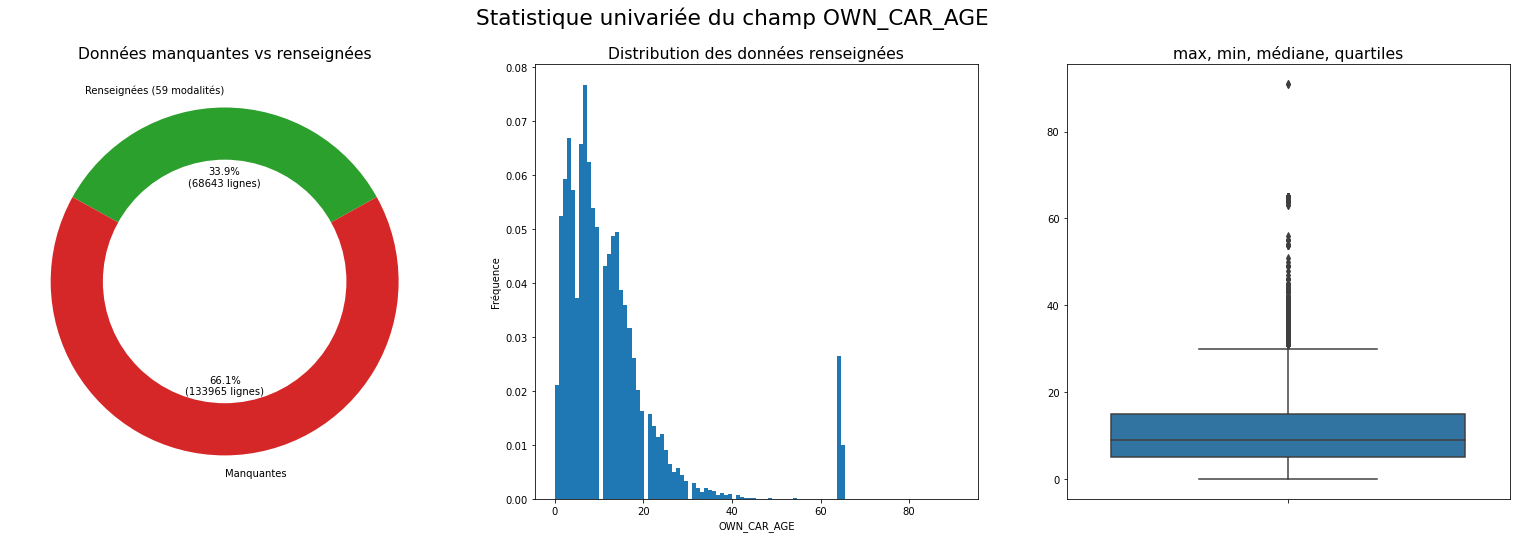

Mesures de position
 - Moyenne: 12.26
 - Médiane: 9.0
Mesures de dispertion
 - Ecart type: 12.08
 - Min: 0.0
 - Q25: 5.0
 - Q75: 15.0
 - Max: 91.0
Mesures de forme
 - Skewness (asymétrie): 2.72
 - Kurtosis (applatissement): 8.98


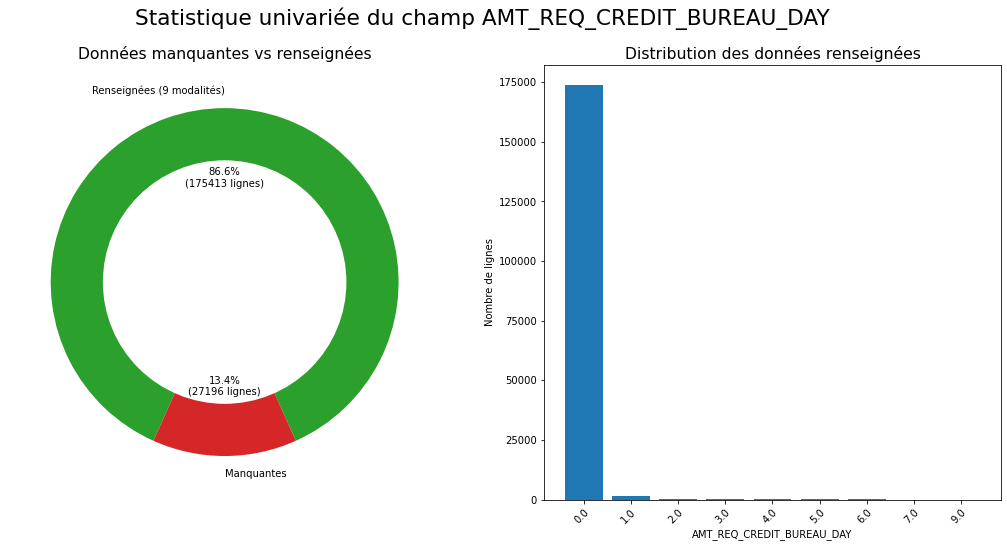

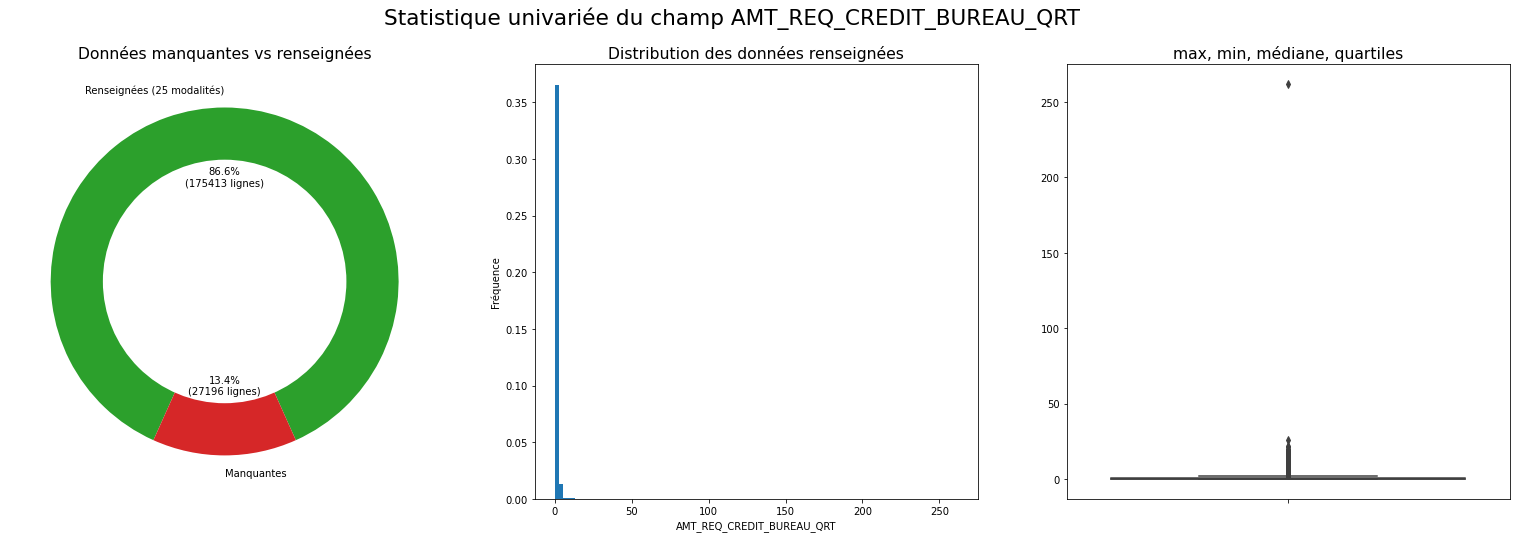

Mesures de position
 - Moyenne: 0.59
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 1.28
 - Min: 0.0
 - Q25: 0.0
 - Q75: 1.0
 - Max: 262.0
Mesures de forme
 - Skewness (asymétrie): 51.32
 - Kurtosis (applatissement): 9832.72


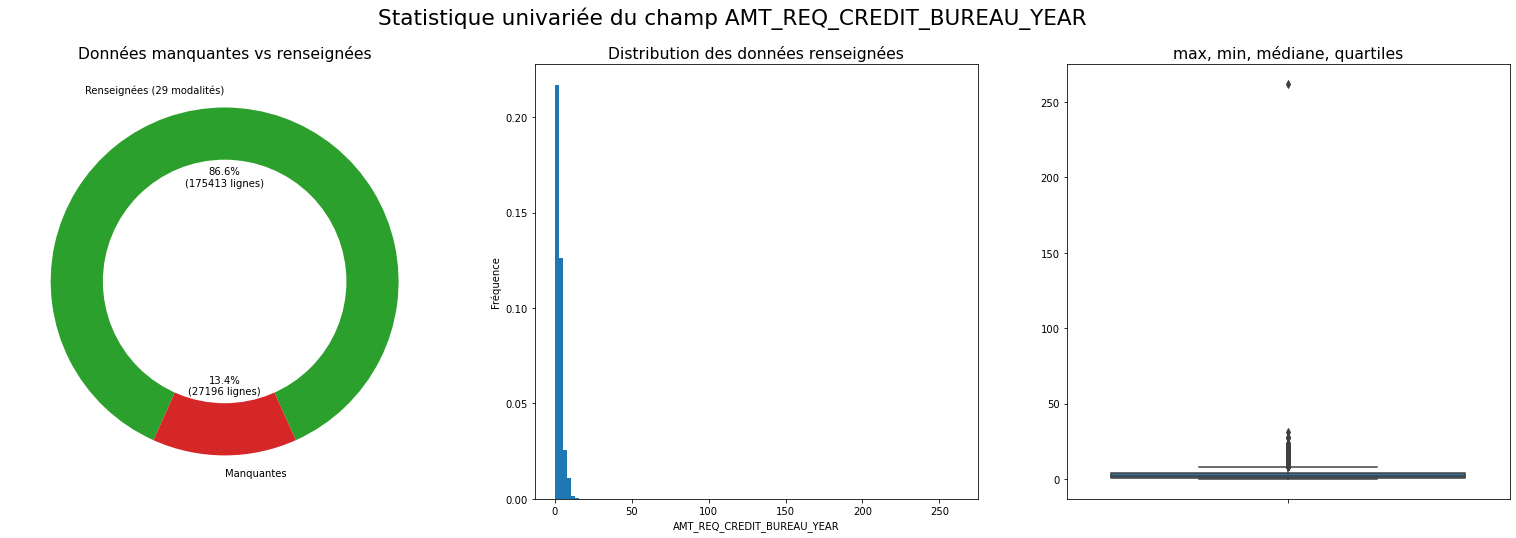

Mesures de position
 - Moyenne: 2.59
 - Médiane: 2.0
Mesures de dispertion
 - Ecart type: 2.31
 - Min: 0.0
 - Q25: 1.0
 - Q75: 4.0
 - Max: 262.0
Mesures de forme
 - Skewness (asymétrie): 9.31
 - Kurtosis (applatissement): 912.61


In [49]:
for col in dfApplication.columns:
    if not ((col.find('MEDI')>0) | (col.find('AVG')>0) | (col.find('MODE')>0)):
        if (dfApplication[col].dtypes != 'object') & (dfApplication[col].nunique() < 100) & (dfApplication[dfApplication[col].isnull()].shape[0] > 2000):
            myDf(dfApplication).Stat(col, statsNan=True)

In [50]:
constantImputer = {}
constantImputer['OWN_CAR_AGE'] = 100
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='constant imputer 100 sur OWN_CAR_AGE' + col, display_plot=False, target='TARGET', identifier='SK_ID_CURR', constantImputer=constantImputer)
results_tmp.append(res)

constantImputer = {}
constantImputer['OWN_CAR_AGE'] = -1
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='constant imputer -1 sur OWN_CAR_AGE' + col, display_plot=False, target='TARGET', identifier='SK_ID_CURR', constantImputer=constantImputer)
results_tmp.append(res)

constantImputer = {}
constantImputer['OWN_CAR_AGE'] = -10
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='constant imputer -10 sur OWN_CAR_AGE' + col, display_plot=False, target='TARGET', identifier='SK_ID_CURR', constantImputer=constantImputer)
results_tmp.append(res)

### Variables continues: constant ou iterative imputer

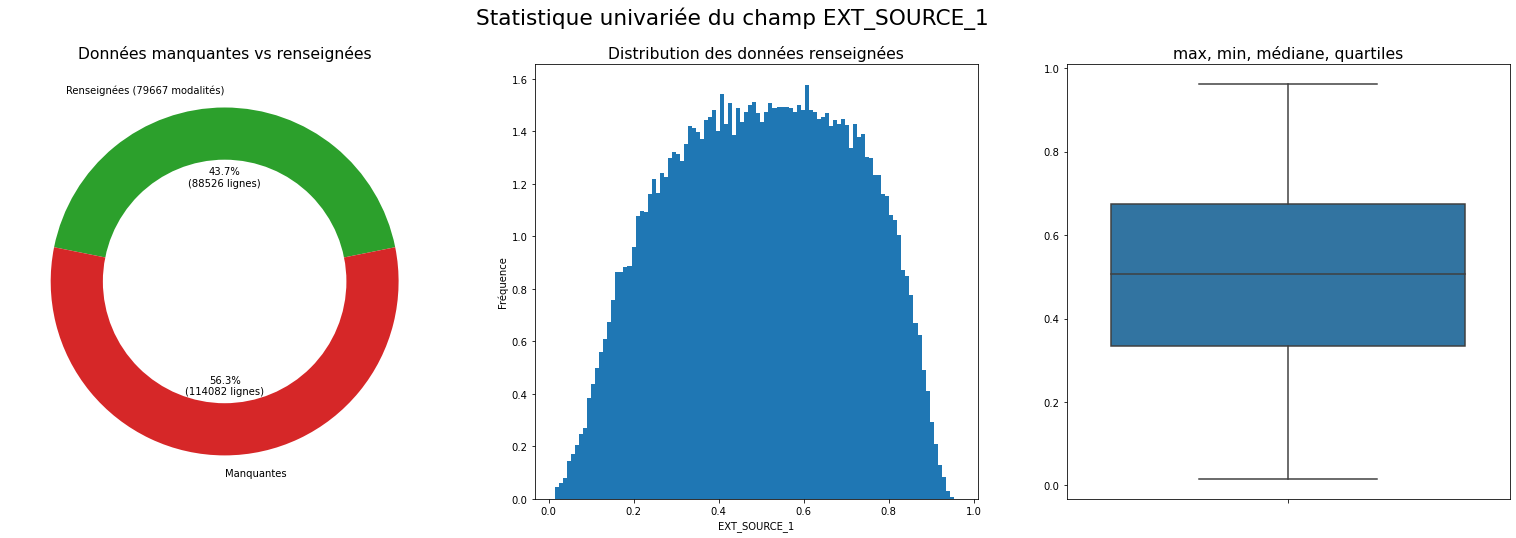

Mesures de position
 - Moyenne: 0.5
 - Médiane: 0.51
Mesures de dispertion
 - Ecart type: 0.21
 - Min: 0.02
 - Q25: 0.33
 - Q75: 0.67
 - Max: 0.96
Mesures de forme
 - Skewness (asymétrie): -0.07
 - Kurtosis (applatissement): -0.97


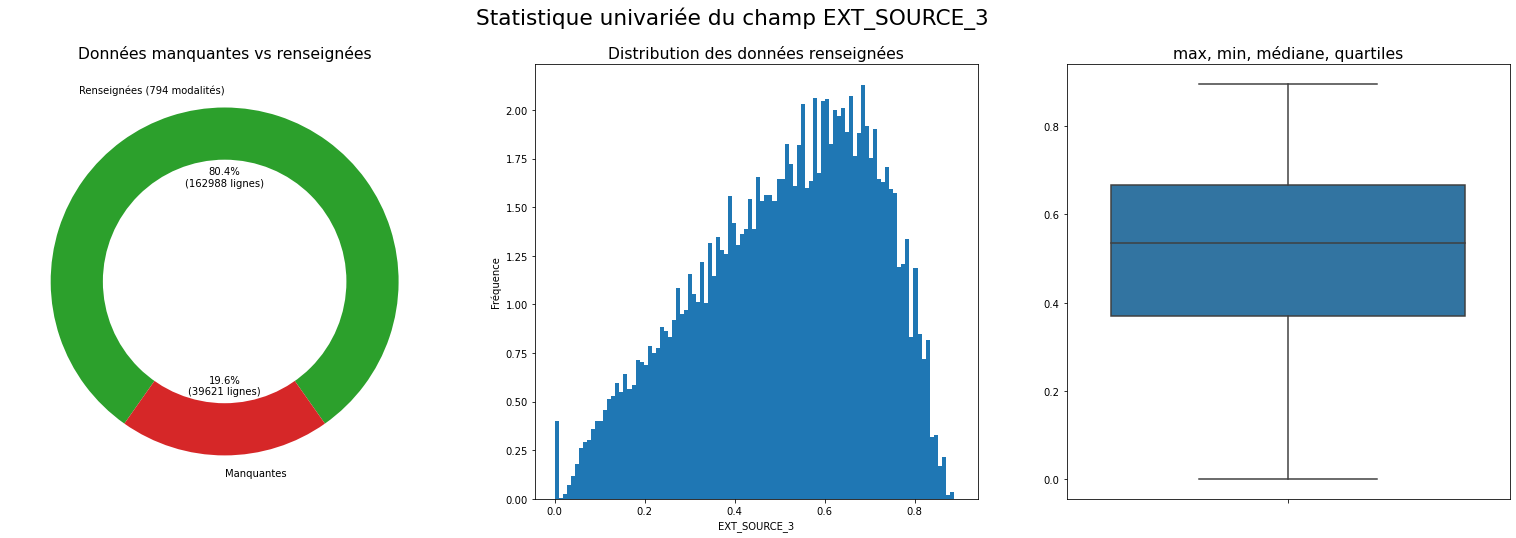

Mesures de position
 - Moyenne: 0.51
 - Médiane: 0.54
Mesures de dispertion
 - Ecart type: 0.19
 - Min: 0.0
 - Q25: 0.37
 - Q75: 0.67
 - Max: 0.9
Mesures de forme
 - Skewness (asymétrie): -0.41
 - Kurtosis (applatissement): -0.66


In [51]:
for col in dfApplication.columns:
    if not ((col.find('MEDI')>0) | (col.find('AVG')>0) | (col.find('MODE')>0)):
        if (dfApplication[col].dtypes != 'object') & (dfApplication[col].nunique() >= 100) & (dfApplication[dfApplication[col].isnull()].shape[0] > 2000):
            myDf(dfApplication).Stat(col, statsNan=True)

In [52]:
constantImputer = {}
constantImputer['EXT_SOURCE_1'] = 0
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='constant imputer 0 sur EXT_SOURCE_1' + col, display_plot=False, target='TARGET', identifier='SK_ID_CURR', constantImputer=constantImputer)
results_tmp.append(res)

constantImputer = {}
constantImputer['EXT_SOURCE_1'] = -1
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='constant imputer -1 sur EXT_SOURCE_1' + col, display_plot=False, target='TARGET', identifier='SK_ID_CURR', constantImputer=constantImputer)
results_tmp.append(res)

iterativeImputer = ['EXT_SOURCE_1']
constantImputer = {}
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='iterative imputer sur EXT_SOURCE_1' + col, display_plot=False, target='TARGET', identifier='SK_ID_CURR', constantImputer=constantImputer)
results_tmp.append(res)


constantImputer = {}
constantImputer['EXT_SOURCE_3'] = 0
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='constant imputer 0 sur EXT_SOURCE_3' + col, display_plot=False, target='TARGET', identifier='SK_ID_CURR', constantImputer=constantImputer)
results_tmp.append(res)

constantImputer = {}
constantImputer['EXT_SOURCE_3'] = 1
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='constant imputer 1 sur EXT_SOURCE_3' + col, display_plot=False, target='TARGET', identifier='SK_ID_CURR', constantImputer=constantImputer)
results_tmp.append(res)

iterativeImputer = ['EXT_SOURCE_3']
constantImputer = {}
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='iterative imputer sur EXT_SOURCE_3' + col, display_plot=False, target='TARGET', identifier='SK_ID_CURR', constantImputer=constantImputer)
results_tmp.append(res)



### Bilan

In [54]:
results_tmp_svg = results_tmp.copy()

In [55]:
results_tmp= pd.concat(results_tmp).groupby('title').mean().reset_index().sort_values('timestamp').reset_index(drop=True)
results_tmp = results_tmp[['title','roc_auc_train','roc_auc_test','pr_auc_train','pr_auc_test']]
roc_auc_test_ini = results_tmp[results_tmp.title == 'Initial'].roc_auc_test.values[0]
pr_auc_test_ini = results_tmp[results_tmp.title == 'Initial'].pr_auc_test.values[0]
results_tmp['gain_roc'] = results_tmp.apply(lambda x: 1000 * (x.roc_auc_test - roc_auc_test_ini), axis=1)
results_tmp['gain_pr'] = results_tmp.apply(lambda x: 1000 * (x.pr_auc_test - pr_auc_test_ini), axis=1)
results_tmp['gain'] = results_tmp.apply(lambda x: 1000 * (x.roc_auc_test - roc_auc_test_ini + x.pr_auc_test - pr_auc_test_ini), axis=1)
results_tmp

,title,roc_auc_train,roc_auc_test,pr_auc_train,pr_auc_test,gain_roc,gain_pr,gain
0,Initial,0.818923,0.782068,0.339935,0.274388,0.000000,0.000000,0.000000
1,missing imputer sur variables appartement,0.818850,0.781911,0.339528,0.274013,-0.157596,-0.375233,-0.532829
2,missing imputer sur OCCUPATION_TYPE,0.818977,0.781841,0.339911,0.274107,-0.226934,-0.281493,-0.508426
3,missing imputer sur ORGANIZATION_TYPE,0.818832,0.781563,0.339361,0.273984,-0.505009,-0.404400,-0.909409
4,missing imputer sur PREV_NAME_TYPE_SUITE,0.818951,0.782036,0.339839,0.274393,-0.031900,0.004378,-0.027522
5,missing imputer sur PREV_NAME_GOODS_CATEGORY,0.818854,0.782071,0.339808,0.274071,0.002847,-0.317302,-0.314455
6,missing imputer sur PREV_NAME_SELLER_INDUSTRY,0.818900,0.781869,0.339746,0.274204,-0.198907,-0.184819,-0.383726
7,missing imputer sur BURO_CREDIT_ACTIVE,0.818904,0.781810,0.339779,0.273698,-0.258526,-0.690596,-0.949121
8,missing imputer sur BURO_CREDIT_TYPE,0.818914,0.782118,0.339587,0.274336,0.049499,-0.052409,-0.002910
9,missing imputer sur PREV_NAME_CASH_LOAN_PURPOSE,0.818943,0.781862,0.339355,0.274705,-0.206745,0.316370,0.109625


## Essai de kBinsTransformers

In [70]:
results_tmp = []

In [71]:
model = LGBMClassifier(max_depth=7, learning_rate=0.125, num_leaves=8, min_child_samples=300, subsample_for_bin=25000, n_estimators=300, n_jobs=-1)
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='Initial', display_plot=False, target='TARGET', identifier='SK_ID_CURR')
results_tmp.append(res)

In [ ]:
cols = list(dfApplication.columns)
cols.remove('TARGET')
cols.remove('SK_ID_CURR')
for col in cols:
    if (dfApplication[col].dtypes != 'object') & (dfApplication[col].nunique() >= 1000):
        kbins50=[col]
        res = evaluateRocPrCurves(dfApplication, model=model, title_plot='kbins sur '+ col, display_plot=False, target='TARGET', identifier='SK_ID_CURR',kbins50=kbins50)
        results_tmp.append(res)

In [ ]:
results_tmp= pd.concat(results_tmp).groupby('title').mean().reset_index().sort_values('timestamp').reset_index(drop=True)
results_tmp = results_tmp[['title','roc_auc_train','roc_auc_test','pr_auc_train','pr_auc_test']]
roc_auc_test_ini = results_tmp[results_tmp.title == 'Initial'].roc_auc_test.values[0]
pr_auc_test_ini = results_tmp[results_tmp.title == 'Initial'].pr_auc_test.values[0]
results_tmp['gain_roc'] = results_tmp.apply(lambda x: 1000 * (x.roc_auc_test - roc_auc_test_ini), axis=1)
results_tmp['gain_pr'] = results_tmp.apply(lambda x: 1000 * (x.pr_auc_test - pr_auc_test_ini), axis=1)
results_tmp['gain'] = results_tmp.apply(lambda x: 1000 * (x.roc_auc_test - roc_auc_test_ini + x.pr_auc_test - pr_auc_test_ini), axis=1)
results_tmp = results_tmp[results_tmp.title != 'Initial']
results_kbins = results_tmp

In [89]:
results_kbins[results_kbins.gain>0].sort_values('gain', ascending=False)

,title,roc_auc_train,roc_auc_test,pr_auc_train,pr_auc_test,gain_roc,gain_pr,gain
28,kbins sur PREV_AMT_CREDIT_ACTIVE_REIMBURSED_INDIC,0.818925,0.782423,0.339634,0.274946,0.354982,0.557286,0.912268
10,kbins sur APARTMENTS_AVG,0.818870,0.782507,0.339569,0.274767,0.438671,0.378449,0.817119
17,kbins sur LANDAREA_MODE,0.818800,0.782471,0.339546,0.274649,0.402450,0.261083,0.663533
45,kbins sur PREV_AMT_GOODS_PRICE,0.818839,0.782101,0.339538,0.274910,0.032661,0.521802,0.554463
84,kbins sur INSTALPAYMT_AMT_PAYMENT,0.818913,0.782342,0.339953,0.274635,0.273806,0.247103,0.520909
74,kbins sur CREDCARD_CNT_DRAWINGS_ATM_CURRENT,0.819066,0.782262,0.340259,0.274672,0.194055,0.283663,0.477717
52,kbins sur PREV_DAYS_TERMINATION,0.818811,0.782035,0.339463,0.274855,-0.032907,0.466601,0.433694
1,kbins sur AMT_INCOME_TOTAL,0.818817,0.782390,0.339174,0.274491,0.321364,0.103083,0.424447
75,kbins sur CREDCARD_CNT_DRAWINGS_CURRENT,0.818966,0.782302,0.339668,0.274503,0.233518,0.115013,0.348531
35,kbins sur INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS,0.818891,0.782091,0.339877,0.274678,0.022260,0.289762,0.312022


In [101]:
results_tmp = []

In [102]:
model = LGBMClassifier(max_depth=7, learning_rate=0.125, num_leaves=8, min_child_samples=300, subsample_for_bin=25000, n_estimators=300, n_jobs=-1)
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='Initial', display_plot=False, target='TARGET', identifier='SK_ID_CURR')
results_tmp.append(res)

In [103]:
kbins50 = []
for col in results_kbins[results_kbins.gain>0].title:
    kbins50.append(col.split(' ')[2])
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='kbins', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50)
results_tmp.append(res)

In [104]:
pd.concat(results_tmp).groupby('title').mean().reset_index().sort_values('timestamp').reset_index(drop=True)

,title,roc_auc_train,roc_auc_test,pr_auc_train,pr_auc_test,time_train,time_pred,nb_feat,nb_train,timestamp
0,Initial,0.818923,0.782068,0.339935,0.274388,4.944150,1.445674,152,182349,1.615899e+09
1,kbins,0.818379,0.782516,0.338712,0.274768,6.041529,1.633219,152,182349,1.615899e+09


In [9]:
kbins50 = ['AMT_INCOME_TOTAL',
 'APARTMENTS_AVG',
 'COMMONAREA_AVG',
 'LIVINGAREA_AVG',
 'LANDAREA_MODE',
 'NONLIVINGAREA_MODE',
 'PREV_AMT_CREDIT_ACTIVE_REIMBURSED_INDIC',
 'INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS',
 'PREV_AMT_APPLICATION',
 'PREV_AMT_GOODS_PRICE',
 'PREV_DAYS_LAST_DUE',
 'PREV_DAYS_TERMINATION',
 'CREDCARD_AMT_DRAWINGS_CURRENT',
 'CREDCARD_AMT_RECEIVABLE_PRINCIPAL',
 'CREDCARD_CNT_DRAWINGS_ATM_CURRENT',
 'CREDCARD_CNT_DRAWINGS_CURRENT',
 'CREDCARD_CNT_DRAWINGS_POS_CURRENT',
 'POSCASH_MONTHS_BALANCE',
 'INSTALPAYMT_DAYS_ENTRY_PAYMENT',
 'INSTALPAYMT_AMT_INSTALMENT',
 'INSTALPAYMT_AMT_PAYMENT']

## Scaler optimisation

In [108]:
results_tmp = []

defaultScaler = MinMaxScaler()
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='MinMax', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, defaultScaler=defaultScaler)
results_tmp.append(res)

defaultScaler = StandardScaler()
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='Standard', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, defaultScaler=defaultScaler)
results_tmp.append(res)

defaultScaler = RobustScaler()
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='Robust', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, defaultScaler=defaultScaler)
results_tmp.append(res)

pd.concat(results_tmp).groupby('title').mean().reset_index().sort_values('timestamp').reset_index(drop=True)

,title,roc_auc_train,roc_auc_test,pr_auc_train,pr_auc_test,time_train,time_pred,nb_feat,nb_train,timestamp
0,MinMax,0.818379,0.782516,0.338712,0.274768,6.356329,1.726433,152,182349,1.615902e+09
1,Standard,0.818412,0.782615,0.338366,0.274137,7.795216,1.747252,152,182349,1.615902e+09
2,Robust,0.818520,0.782369,0.338820,0.274995,6.446701,1.622779,152,182349,1.615902e+09


In [109]:
imp = featureImportance(imputeScaleAndEncode(dfApplication, target='TARGET', identifier='SK_ID_CURR'), target='TARGET', identifier='SK_ID_CURR', model=model)
imp[['feature','impMean']]

,feature,impMean
0,EXT_SOURCE_3,77.0
1,EXT_SOURCE_1,70.0
2,EXT_SOURCE_2,66.0
3,AMT_CREDIT,64.0
4,DAYS_BIRTH,58.0
5,POSCASH_CNT_INSTALMENT_FUTURE,51.0
6,DAYS_EMPLOYED,44.0
7,AMT_GOODS_PRICE,40.0
8,INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG,40.0
9,PREVBURO_LAST_DAYS_DECISION,39.0


In [122]:
results_tmp = []
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='Initial', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50)
results_tmp.append(res)

In [115]:
for index, row in imp.head(10).iterrows():
    if dfApplication[row.feature].dtypes != 'object':
        print(row.feature)
        standard, robust = [row.feature], []
        res = evaluateRocPrCurves(dfApplication, model=model, title_plot=row.feature+' standard', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, standard=standard, robust=robust)
        results_tmp.append(res)
        standard, robust = [], [row.feature]
        res = evaluateRocPrCurves(dfApplication, model=model, title_plot=row.feature+' robust', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, standard=standard, robust=robust)
        results_tmp.append(res)

EXT_SOURCE_3
EXT_SOURCE_1
EXT_SOURCE_2
AMT_CREDIT
DAYS_BIRTH
POSCASH_CNT_INSTALMENT_FUTURE
DAYS_EMPLOYED
AMT_GOODS_PRICE
INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG
PREVBURO_LAST_DAYS_DECISION


In [124]:
results_tmp_svg = results_tmp.copy()

In [125]:
results_tmp= pd.concat(results_tmp).groupby('title').mean().reset_index().sort_values('timestamp').reset_index(drop=True)
results_tmp = results_tmp[['title','roc_auc_train','roc_auc_test','pr_auc_train','pr_auc_test']]
roc_auc_test_ini = results_tmp[results_tmp.title == 'Initial'].roc_auc_test.values[0]
pr_auc_test_ini = results_tmp[results_tmp.title == 'Initial'].pr_auc_test.values[0]
results_tmp['gain_roc'] = results_tmp.apply(lambda x: 1000 * (x.roc_auc_test - roc_auc_test_ini), axis=1)
results_tmp['gain_pr'] = results_tmp.apply(lambda x: 1000 * (x.pr_auc_test - pr_auc_test_ini), axis=1)
results_tmp['gain'] = results_tmp.apply(lambda x: 1000 * (x.roc_auc_test - roc_auc_test_ini + x.pr_auc_test - pr_auc_test_ini), axis=1)


,title,roc_auc_train,roc_auc_test,pr_auc_train,pr_auc_test,gain_roc,gain_pr,gain
0,EXT_SOURCE_3 standard,0.818332,0.781816,0.338198,0.273691,-0.699443,-1.076137,-1.775579
1,EXT_SOURCE_3 robust,0.818332,0.781816,0.338198,0.273691,-0.699443,-1.076137,-1.775579
2,EXT_SOURCE_1 standard,0.818280,0.782666,0.338415,0.275031,0.150832,0.263874,0.414706
3,EXT_SOURCE_1 robust,0.818280,0.782666,0.338415,0.275031,0.150832,0.263874,0.414706
4,EXT_SOURCE_2 standard,0.818239,0.782965,0.339153,0.273841,0.449182,-0.926528,-0.477347
5,EXT_SOURCE_2 robust,0.818239,0.782965,0.339153,0.273841,0.449182,-0.926528,-0.477347
6,AMT_CREDIT standard,0.818256,0.781948,0.338822,0.274385,-0.568072,-0.382781,-0.950853
7,AMT_CREDIT robust,0.818256,0.781948,0.338822,0.274385,-0.568072,-0.382781,-0.950853
8,DAYS_BIRTH standard,0.818266,0.783038,0.339004,0.274638,0.522252,-0.129264,0.392989
9,DAYS_BIRTH robust,0.818266,0.783038,0.339004,0.274638,0.522252,-0.129264,0.392989


In [126]:
results_tmp[results_tmp.gain > 0].sort_values('gain', ascending=False)

,title,roc_auc_train,roc_auc_test,pr_auc_train,pr_auc_test,gain_roc,gain_pr,gain
10,POSCASH_CNT_INSTALMENT_FUTURE standard,0.818266,0.782832,0.338517,0.275199,0.316162,0.431299,0.747461
11,POSCASH_CNT_INSTALMENT_FUTURE robust,0.818266,0.782832,0.338517,0.275199,0.316162,0.431299,0.747461
14,AMT_GOODS_PRICE standard,0.818339,0.782801,0.338536,0.274967,0.285451,0.199044,0.484495
15,AMT_GOODS_PRICE robust,0.818339,0.782801,0.338536,0.274967,0.285451,0.199044,0.484495
2,EXT_SOURCE_1 standard,0.818280,0.782666,0.338415,0.275031,0.150832,0.263874,0.414706
3,EXT_SOURCE_1 robust,0.818280,0.782666,0.338415,0.275031,0.150832,0.263874,0.414706
8,DAYS_BIRTH standard,0.818266,0.783038,0.339004,0.274638,0.522252,-0.129264,0.392989
9,DAYS_BIRTH robust,0.818266,0.783038,0.339004,0.274638,0.522252,-0.129264,0.392989


In [10]:
standard = ['EXT_SOURCE_1',
 'DAYS_BIRTH',
 'POSCASH_CNT_INSTALMENT_FUTURE',
 'AMT_GOODS_PRICE']
standard = ['POSCASH_CNT_INSTALMENT_FUTURE','AMT_GOODS_PRICE']

In [139]:
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='Initial', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, standard=standard)
res.groupby('title').mean().reset_index().sort_values('timestamp').reset_index(drop=True)

,title,roc_auc_train,roc_auc_test,pr_auc_train,pr_auc_test,time_train,time_pred,nb_feat,nb_train,timestamp
0,Initial,0.818278,0.782752,0.338463,0.274986,4.772773,1.528189,152,182349,1.615908e+09


## Over-under sampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN

In [35]:
model = LGBMClassifier(max_depth=7, learning_rate=0.125, num_leaves=8, min_child_samples=300, subsample_for_bin=25000, n_estimators=300, n_jobs=-1)

In [39]:
results_tmp = []
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='Initial', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50)
results_tmp.append(res)

In [11]:
over=RandomOverSampler()
under=None
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='RandomOverSampler() | None', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

In [12]:
over=None
under=RandomUnderSampler()
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='None | RandomUnderSampler()', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

In [13]:
over=RandomOverSampler()
under=RandomUnderSampler()
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='RandomOverSampler() | RandomUnderSampler()', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

In [16]:
over=RandomOverSampler(sampling_strategy=0.3)
under=None
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='RandomOverSampler(sampling_strategy=0.3) | None', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

In [17]:
over=RandomOverSampler(sampling_strategy=0.7)
under=None
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='RandomOverSampler(sampling_strategy=0.7) | None', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

In [18]:
over=RandomOverSampler(sampling_strategy=1)
under=None
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='RandomOverSampler(sampling_strategy=1) | None', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

In [19]:
over=None
under=RandomUnderSampler(sampling_strategy=0.3)
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='None | RandomUnderSampler(sampling_strategy=0.3)', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

In [20]:
over=None
under=RandomUnderSampler(sampling_strategy=0.7)
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='None | RandomUnderSampler(sampling_strategy=0.7)', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

In [21]:
over=None
under=RandomUnderSampler(sampling_strategy=1)
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='None | RandomUnderSampler(sampling_strategy=1)', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

In [33]:
over=SMOTE()
under=None
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='SMOTE() | None', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

In [34]:
over=SMOTE(sampling_strategy=0.1, k_neighbors=5)
under=None
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='SMOTE(sampling_strategy=0.1, k_neighbors=5) | None', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

In [35]:
over=SMOTE(sampling_strategy=0.5, k_neighbors=5)
under=None
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='SMOTE(sampling_strategy=0.5, k_neighbors=5) | None', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

In [36]:
over=SMOTE(sampling_strategy=1, k_neighbors=5)
under=None
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='SMOTE(sampling_strategy=1, k_neighbors=5) | None', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

In [39]:
over=BorderlineSMOTE(kind='borderline-1')
under=None
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='BorderlineSMOTE(kind=borderline-1) | None', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

In [40]:
over=BorderlineSMOTE(kind='borderline-2')
under=None
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='BorderlineSMOTE(kind=borderline-2) | None', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

In [44]:
over=BorderlineSMOTE(kind='borderline-2', sampling_strategy=0.1, k_neighbors=5)
under=None
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='BorderlineSMOTE(kind=borderline-2, sampling_strategy=0.1, k_neighbors=5) | None', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

In [45]:
over=BorderlineSMOTE(kind='borderline-2', sampling_strategy=0.5, k_neighbors=5)
under=None
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='BorderlineSMOTE(kind=borderline-2, sampling_strategy=0.5, k_neighbors=5) | None', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

In [46]:
over= BorderlineSMOTE(kind='borderline-2', sampling_strategy=1, k_neighbors=5)
under=None
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='BorderlineSMOTE(kind=borderline-2, sampling_strategy=1, k_neighbors=5) | None', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

In [14]:
over=ADASYN()
under=None
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='ADASYN() | None', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

In [18]:
over=None
under = NearMiss(version=1, n_neighbors=3)
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='None | NearMiss(version=1, n_neighbors=3)', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

In [ ]:
over=None
under = NearMiss(version=2, n_neighbors=3)
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='None | NearMiss(version=2, n_neighbors=3)', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

In [ ]:
over=None
under = NearMiss(version=3, n_neighbors_ver3=3)
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='None | NearMiss(version=3, n_neighbors_ver3=3)', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

In [ ]:
over=None
under = CondensedNearestNeighbour(n_neighbors=1)
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='None | CondensedNearestNeighbour(n_neighbors=1)', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

In [ ]:
over=None
under = TomekLinks()
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='None | TomekLinks()', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

In [ ]:
over=None
under = EditedNearestNeighbours(n_neighbors=3)
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='None | EditedNearestNeighbours(n_neighbors=3)', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

In [ ]:
over=None
under = OneSidedSelection(n_neighbors=1, n_seeds_S=200)
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='None | OneSidedSelection(n_neighbors=1, n_seeds_S=200)', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

In [ ]:
over=None
under = NeighbourhoodCleaningRule(n_neighbors=3, threshold_cleaning=0.5)
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='None | NeighbourhoodCleaningRule(n_neighbors=3, threshold_cleaning=0.5)', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

In [13]:
over=None
under = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='None | SMOTETomek(tomek=TomekLinks(sampling_strategy=majority))', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

KeyboardInterrupt: 

In [14]:
over=None
under = SMOTEENN()
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='None | SMOTEENN()', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

KeyboardInterrupt: 

In [47]:
pd.concat(results_tmp).groupby('title').mean().reset_index().sort_values('timestamp').reset_index(drop=True)

,title,roc_auc_train,roc_auc_test,pr_auc_train,pr_auc_test,time_train,time_pred,nb_feat,nb_train,timestamp
0,Initial,0.818379,0.782516,0.338712,0.274768,7.739383,1.900598,152,182349,1.615923e+09
1,SMOTE() | None,0.800411,0.777909,0.307368,0.266298,18.785233,1.956358,152,182349,1.615923e+09
2,"SMOTE(sampling_strategy=0.1, k_neighbors=5) | None",0.815386,0.782308,0.332995,0.273595,11.285184,1.910507,152,182349,1.615923e+09
3,"SMOTE(sampling_strategy=0.5, k_neighbors=5) | None",0.804120,0.779708,0.314219,0.269599,13.934275,1.923276,152,182349,1.615924e+09
4,"SMOTE(sampling_strategy=1, k_neighbors=5) | None",0.800385,0.777538,0.307900,0.264827,15.874913,1.869994,152,182349,1.615924e+09
5,BorderlineSMOTE(kind=borderline-1) | None,0.800336,0.776945,0.307495,0.265365,60.382553,1.912616,152,182349,1.615925e+09
6,BorderlineSMOTE(kind=borderline-2) | None,0.801543,0.778850,0.309940,0.268639,60.996075,1.980480,152,182349,1.615925e+09
7,"BorderlineSMOTE(kind=borderline-2, sampling_strategy=0.1, k_neighbors=5) | None",0.815614,0.781625,0.333004,0.272440,55.108157,1.887596,152,182349,1.615926e+09
8,"BorderlineSMOTE(kind=borderline-2, sampling_strategy=0.5, k_neighbors=5) | None",0.805211,0.780549,0.316617,0.270831,57.643042,1.919389,152,182349,1.615927e+09
9,"BorderlineSMOTE(kind=borderline-2, sampling_strategy=1, k_neighbors=5) | None",0.801518,0.778365,0.309899,0.267623,58.257848,1.879968,152,182349,1.615927e+09


# Métriques finales

In [29]:
dfApplication = load(open('dfApplicationTrain.pkl','rb'))

In [31]:
cols = ['SK_ID_CURR',
 'TARGET',
 'EXT_SOURCE_1',
 'EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'DAYS_BIRTH',
 'AMT_CREDIT',
 'POSCASH_CNT_INSTALMENT_FUTURE',
 'INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG',
 'AMT_GOODS_PRICE',
 'AMT_ANNUITY',
 'PREVBURO_LAST_DAYS_DECISION',
 'DAYS_EMPLOYED',
 'POSCASH_CNT_INSTALMENT_FUTURE_LEFT',
 'POSCASH_CNT_INSTALMENT_FUTURE_DONE',
 'DAYS_ID_PUBLISH',
 'BURO_AMT_CREDIT_SUM',
 'PREV_AMT_ANNUITY',
 'BURO_AMT_CREDIT_ACTIVE',
 'CODE_GENDER',
 'BURO_AMT_CREDIT_MAX_OVERDUE',
 'DAYS_REGISTRATION',
 'INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS',
 'BURO_AMT_CREDIT_SUM_DEBT',
 'BURO_AMT_CREDIT_COMPLETED',
 'RATIO_ANNUITY_INCOME',
 'PREV_AMT_COMPLETED',
 'INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_POS',
 'PREVBURO_DAYS_DIFF',
 'POSCASH_SK_DPD_DEF',
 'PREV_NAME_YIELD_GROUP_ORD',
 'ORGANIZATION_TYPE',
 'CREDCARD_CNT_DRAWINGS_ATM_CURRENT',
 'PREV_AMT_CREDIT_ACTIVE_REIMBURSED_INDIC',
 'NAME_FAMILY_STATUS',
 'NB_DOC_FURNISHED',
 'BURO_DAYS_CREDIT',
 'PREV_AMT_CREDIT_ACTIVE',
 'PREV_AMT_DOWN_PAYMENT',
 'OCCUPATION_TYPE',
 'DAYS_LAST_PHONE_CHANGE',
 'BURO_AMT_CREDIT_SUM_LIMIT',
 'NAME_EDUCATION_TYPE',
 'INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_NEG',
 'CREDCARD_CNT_DRAWINGS_CURRENT',
 'CREDCARD_MONTHS_BALANCE',
 'REGION_RATING_CLIENT_W_CITY',
 'NAME_INCOME_TYPE',
 'BURO_AMT_CREDIT_SUM_OVERDUE',
 'PREV_AMT_ANNUITY_ACTIVE',
 'INSTALPAYMT_AMT_INSTALMENT',
 'REGION_POPULATION_RELATIVE',
 'OWN_CAR_AGE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'PREV_CODE_REJECT_REASON',
 'FLAG_DOCUMENT_3',
 'FLAG_OWN_CAR',
 'PREV_HOUR_APPR_PROCESS_START',
 'AMT_INCOME_TOTAL',
 'PREV_SELLERPLACE_AREA',
 'CREDCARD_AMT_DRAWINGS_ATM_CURRENT',
 'CREDCARD_AMT_BALANCE',
 'PREV_NFLAG_INSURED_ON_APPROVAL',
 'BURO_DAYS_CREDIT_UPDATE',
 'INSTALPAYMT_AMT_PAYMENT',
 'CREDCARD_AMT_PAYMENT_TOTAL_CURRENT',
 'PREV_DAYS_DECISION',
 'PREV_NB_REFUSED',
 'WEEKDAY_APPR_PROCESS_START',
 'CREDCARD_SK_DPD_DEF',
 'PREV_DAYS_TERMINATION',
 'CREDCARD_AMT_PAYMENT_CURRENT',
 'BURO_DAYS_CREDIT_ENDDATE',
 'CREDCARD_AMT_RECIVABLE',
 'PREV_PRODUCT_COMBINATION',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'PREV_NAME_SELLER_INDUSTRY',
 'INSTALPAYMT_DAYS_ENTRY_PAYMENT',
 'PREV_DAYS_LAST_DUE_1ST_VERSION',
 'REG_CITY_NOT_LIVE_CITY',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'PREV_NAME_CONTRACT_STATUS',
 'FLAG_DOCUMENT_11',
 'PREV_NAME_TYPE_SUITE',
 'INSTALPAYMT_DAYS_INSTALMENT',
 'PREV_RATE_DOWN_PAYMENT',
 'PREV_CNT_PAYMENT',
 'FLAG_WORK_PHONE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'POSCASH_CNT_INSTALMENT',
 'CREDCARD_AMT_CREDIT_LIMIT_ACTUAL',
 'PREV_NAME_CLIENT_TYPE',
 'CREDCARD_CNT_DRAWINGS_POS_CURRENT',
 'ELEVATORS_AVG',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'PREV_NAME_CASH_LOAN_PURPOSE',
 'BUROBAL_MONTHS_BALANCE',
 'PREV_LAST_NAME_CONTRACT_STATUS',
 'CREDCARD_AMT_DRAWINGS_CURRENT',
 'CREDCARD_AMT_DRAWINGS_OTHER_CURRENT',
 'CREDCARD_CNT_INSTALMENT_MATURE_CUM',
 'FLAG_DOCUMENT_18',
 'PREV_DAYS_LAST_DUE',
 'PREV_AMT_GOODS_PRICE',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'NONLIVINGAPARTMENTS_MEDI',
 'YEARS_BEGINEXPLUATATION_AVG',
 'COMMONAREA_MEDI',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'CREDCARD_AMT_TOTAL_RECEIVABLE',
 'PREV_NAME_GOODS_CATEGORY',
 'PREV_NAME_PORTFOLIO',
 'LIVINGAPARTMENTS_AVG',
 'CREDCARD_AMT_DRAWINGS_POS_CURRENT',
 'PREV_NB_COMPLETED',
 'LIVINGAREA_AVG',
 'PREV_AMT_APPLICATION',
 'NONLIVINGAREA_MODE',
 'HOUR_APPR_PROCESS_START',
 'PREV_AMT_CREDIT',
 'ENTRANCES_AVG',
 'CNT_CHILDREN',
 'NONLIVINGAPARTMENTS_AVG',
 'COMMONAREA_MODE',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'NAME_HOUSING_TYPE',
 'NAME_TYPE_SUITE',
 'ENTRANCES_MEDI',
 'BUROBAL_SK_DPD',
 'PREV_NAME_CONTRACT_TYPE',
 'PREV_WEEKDAY_APPR_PROCESS_START',
 'BURO_CREDIT_TYPE',
 'NONLIVINGAPARTMENTS_MODE',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'BURO_DAYS_ENDDATE_FACT',
 'FLOORSMIN_MODE',
 'COMMONAREA_AVG',
 'LIVINGAREA_MODE',
 'BURO_AMT_ANNUITY',
 'POSCASH_SK_DPD',
 'BURO_CREDIT_ACTIVE',
 'BASEMENTAREA_AVG',
 'POSCASH_MONTHS_BALANCE',
 'APARTMENTS_AVG',
 'WALLSMATERIAL_MODE',
 'CREDCARD_AMT_RECEIVABLE_PRINCIPAL',
 'TOTALAREA_MODE',
 'FLAG_OWN_REALTY',
 'LIVINGAPARTMENTS_MEDI']

In [32]:
dfApplication = dfApplication[cols]

In [33]:
kbins50 = ['AMT_INCOME_TOTAL',
 'APARTMENTS_AVG',
 'COMMONAREA_AVG',
 'LIVINGAREA_AVG',
 'LANDAREA_MODE',
 'NONLIVINGAREA_MODE',
 'PREV_AMT_CREDIT_ACTIVE_REIMBURSED_INDIC',
 'INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS',
 'PREV_AMT_APPLICATION',
 'PREV_AMT_GOODS_PRICE',
 'PREV_DAYS_LAST_DUE',
 'PREV_DAYS_TERMINATION',
 'CREDCARD_AMT_DRAWINGS_CURRENT',
 'CREDCARD_AMT_RECEIVABLE_PRINCIPAL',
 'CREDCARD_CNT_DRAWINGS_ATM_CURRENT',
 'CREDCARD_CNT_DRAWINGS_CURRENT',
 'CREDCARD_CNT_DRAWINGS_POS_CURRENT',
 'POSCASH_MONTHS_BALANCE',
 'INSTALPAYMT_DAYS_ENTRY_PAYMENT',
 'INSTALPAYMT_AMT_INSTALMENT',
 'INSTALPAYMT_AMT_PAYMENT']

In [34]:
model = LGBMClassifier(max_depth=7, learning_rate=0.125, num_leaves=8, min_child_samples=300, subsample_for_bin=25000, n_estimators=300, n_jobs=-1)

## Cross-validation 10

In [25]:
results_tmp = []
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='Final', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50)
results_tmp.append(res)

In [26]:
pd.concat(results_tmp).groupby('title').mean().reset_index().sort_values('timestamp').reset_index(drop=True)

,title,roc_auc_train,roc_auc_test,pr_auc_train,pr_auc_test,time_train,time_pred,nb_feat,nb_train,timestamp
0,Final,0.80826,0.78168,0.323027,0.276497,17.246227,3.365202,152.0,260499.6,1.616000e+09


## Serie de 10000 train-test split

In [47]:
results_tmp = []

In [ ]:
dump(results_tmp, open('results_tmp.pkl','wb'))

In [48]:
for rnd in np.arange(100):
    res = evaluateRocPrCurves(dfApplication, model=model, title_plot=str(rnd), display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, random_state=rnd)
    results_tmp.append(res)
    #dump(results_tmp, open('results_tmpx.pkl','wb'))

In [5]:
if True:
    results_tmp = load(open('results_tmp.pkl', 'rb'))

In [7]:
results = pd.concat(results_tmp).groupby('title').mean().reset_index().sort_values('timestamp').reset_index(drop=True)

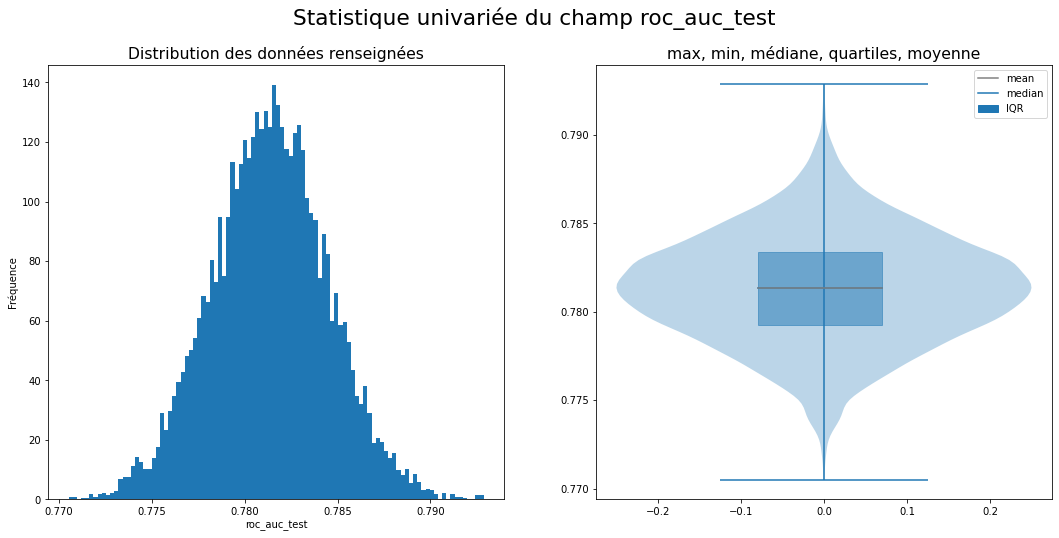

Mesures de position
 - Moyenne: 0.78134
 - Médiane: 0.78136
Mesures de dispertion
 - Ecart type: 0.00313
 - Min: 0.77051
 - Q25: 0.77927
 - Q75: 0.7834
 - Max: 0.79287
Mesures de forme
 - Skewness (asymétrie): 0.011
 - Kurtosis (applatissement): 0.037


In [8]:
myDf(results).Stat('roc_auc_test', violinPlot=True)

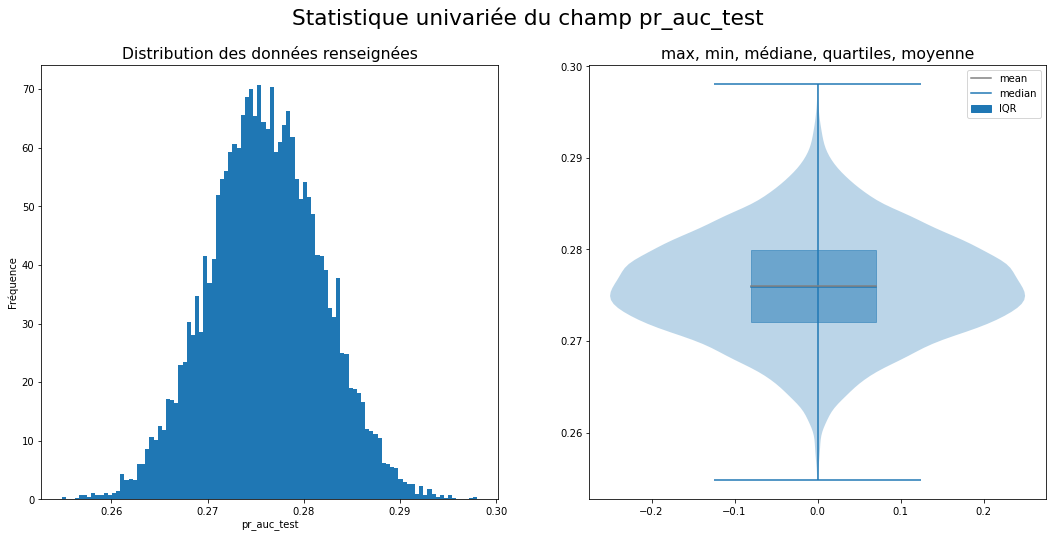

Mesures de position
 - Moyenne: 0.276
 - Médiane: 0.2759
Mesures de dispertion
 - Ecart type: 0.00587
 - Min: 0.25488
 - Q25: 0.27205
 - Q75: 0.27998
 - Max: 0.29803
Mesures de forme
 - Skewness (asymétrie): 0.024
 - Kurtosis (applatissement): -0.01


In [9]:
myDf(results).Stat('pr_auc_test', violinPlot=True)

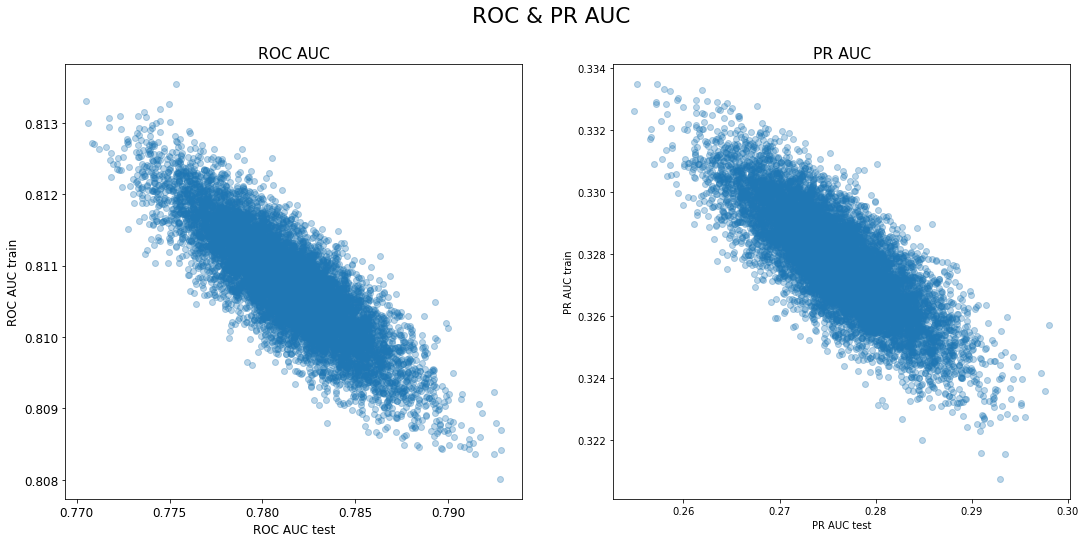

In [10]:
plt.rcParams.update({'font.size':12})

fig = plt.figure(figsize=(1 * (18 * 2/2), 1 * 8))

# 1 - Affichage d'un scatter plot
sub = fig.add_subplot(1,2,1)
plt.rcParams.update({'font.size':13, 'font.style':'italic'})
sub.set_title('ROC AUC')

plt.rcParams.update({'font.size':10, 'font.style':'normal'})
plt.scatter(results.roc_auc_test, results.roc_auc_train, alpha=0.3)
plt.gca().set_xlabel('ROC AUC test')
plt.gca().set_ylabel('ROC AUC train')

# 2 - Affichage de boites parallèles
sub = fig.add_subplot(1,2,2)
plt.rcParams.update({'font.size':13, 'font.style':'italic'})
sub.set_title('PR AUC')

plt.rcParams.update({'font.size':10, 'font.style':'normal'})
plt.scatter(results.pr_auc_test, results.pr_auc_train, alpha=0.3)
plt.gca().set_xlabel('PR AUC test')
plt.gca().set_ylabel('PR AUC train')


plt.rcParams.update({'font.size':18})
plt.suptitle("ROC & PR AUC")

plt.show()


## Evaluation sur le jeu de validation

In [38]:
# à faire

## Feature importance

In [35]:
imp = featureImportance(imputeScaleAndEncode(dfApplication, target='TARGET', identifier='SK_ID_CURR'), target='TARGET', identifier='SK_ID_CURR', model=model)
imp[['feature','impMean']]

,feature,impMean
0,EXT_SOURCE_1,69.0
1,EXT_SOURCE_3,67.0
2,DAYS_BIRTH,66.0
3,EXT_SOURCE_2,65.0
4,AMT_CREDIT,63.0
5,BURO_AMT_CREDIT_SUM,43.0
6,POSCASH_CNT_INSTALMENT_FUTURE,41.0
7,AMT_GOODS_PRICE,41.0
8,DAYS_EMPLOYED,41.0
9,AMT_ANNUITY,40.0


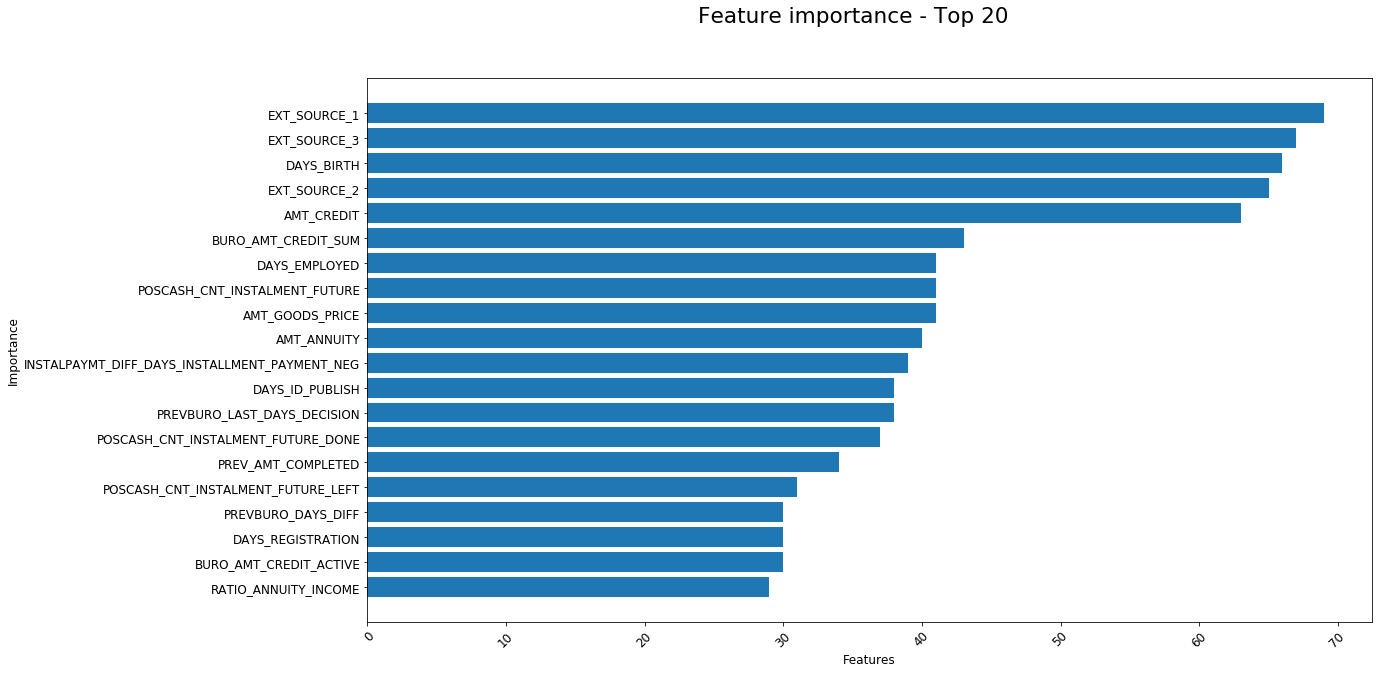

In [36]:
plt.rcParams.update({'font.size':12})

fig = plt.figure(figsize=(18, 10))

impplot = imp[0:20].sort_values('impMean', ascending=True)

sub = fig.add_subplot(1,1,1)

plt.rcParams.update({'font.size':10, 'font.style':'normal'})
plt.barh(impplot['feature'], impplot['impMean'])
plt.gca().set_xlabel('Features')
plt.gca().set_ylabel('Importance')


plt.rcParams.update({'font.size':18})
plt.suptitle("Feature importance - Top 20")

plt.xticks(rotation=45, ha="right", rotation_mode="anchor")

plt.show()

In [37]:
dump(list(imp.feature), open('imp.pkl','wb'))

## Entrainement final du modèle

In [50]:
dfApplicationVal = load(open('dfApplicationVal.pkl','rb'))

In [58]:
dfApplication = load(open('dfApplicationTrain.pkl','rb'))

In [59]:
# à corriger, bug lors du fit
# dfApplication = pd.concat([dfApplication,dfApplicationVal])

In [60]:
dfApplication.shape

(202610, 229)

In [61]:
model = LGBMClassifier(max_depth=7, learning_rate=0.125, num_leaves=8, min_child_samples=300, subsample_for_bin=25000, n_estimators=300, n_jobs=-1)

In [62]:
pipeline = getPipeline(
                        dfApplication,
                        target='TARGET', 
                        identifier='SK_ID_CURR', 
                        kbins50=kbins50,
                        model=model)

In [63]:
pipeline

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('1',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('trans',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-10)),
                                                                  ('scal',
                                                                   IdentityTransformer())]),
                                                  ['NAME_CONTRACT_TYPE',
                                                   'CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALT

In [64]:
y = dfApplication['TARGET']
del dfApplication['SK_ID_CURR']
del dfApplication['TARGET']

In [65]:
pipeline.fit(dfApplication,y)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('1',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('trans',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-10)),
                                                                  ('scal',
                                                                   IdentityTransformer())]),
                                                  ['NAME_CONTRACT_TYPE',
                                                   'CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALT

In [ ]:
dump(pipeline, open('pipeline.pkl','wb'))

## Prédictions

In [92]:
pred = pipeline.predict_proba(dfApplication)
pred = pred.T[1]

In [93]:
pred

array([0.0070194 , 0.07781235, 0.04036979, ..., 0.18268342, 0.32078609,
       0.17195249])

In [113]:
prct_default_seuil = []
seuil = np.arange(1000) /1000
for s in seuil:
    prct_default_seuil.append(0.0+len([p for p in pred if p > s]) / pred.shape[0])

In [116]:
seuil_stat = pd.DataFrame({'seuil':seuil,'prct_default_seuil':prct_default_seuil})

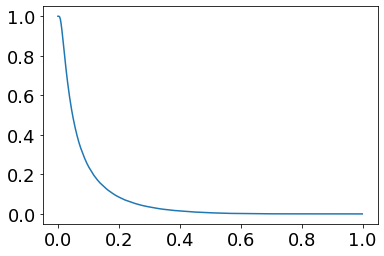

In [115]:
plt.plot(seuil, prct_default_seuil)

In [117]:
dump(seuil_stat, open('seuil_stat.pkl','wb'))